In [1]:
#basic package
import os
import numpy as np
import glob
import pandas as pd
import sys
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import cleaning_processing, preprocessing_Origins
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
#avoid this warnign until its fixed in IPykernel ; DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
print(id_run)
path_cleaning_records = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\GantnerSystem\GantnerCleaning\Results'
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
#create a director if not existing
if not os.path.exists(path_extracted_data_cleaning):
    os.makedirs(path_extracted_data_cleaning)
#features for model
li_cont_select = config.li_cont_select
li_bin = config.li_bin
li_cat_select = config.li_cat_select

change the configuration file if not done yet!
CleaningAnalysis_


# Info on initial batch selection

In [5]:
#download data
df_batch = pd.read_csv(os.path.join(path_cleaning_records,'selectedbirds.csv'), sep=';')
print(df_batch.shape)
df_batch.head(3)

(128, 13)


,is_reliability,type,worker,TagID,backpackID,Pen,date2analyse,starthour,endhour,comment,priorite,duration_h,duration_mn
0,NaN,verification,Masha,2,wp,3,14.10.2020,14,16,NaN,NaN,2,120
1,NaN,verification,Masha,25,wp,4,14.10.2020,14,16,NaN,NaN,2,120
2,NaN,verification,Masha,183,wp,5,14.10.2020,14,16,NaN,NaN,2,120


In [6]:
#number of batches involved per days
print(len(df_batch['date2analyse'].unique()))
print(df_batch.groupby('type')['date2analyse'].agg(lambda x: len(set(x))))
df_batch.groupby('type')['date2analyse'].value_counts()

11
type
cleaning        11
verification     6
Name: date2analyse, dtype: int64


type          date2analyse
cleaning      18.10.2020      15
              17.10.2020      13
              16.10.2020      11
              24.10.2020       9
              15.10.2020       7
              14.10.2020       5
              19.10.2020       5
              23.10.2020       5
              25.10.2020       4
              26.10.2020       4
              21.10.2020       1
verification  14.10.2020       8
              15.10.2020       8
              16.10.2020       8
              21.10.2020       8
              23.10.2020       8
              24.10.2020       8
Name: date2analyse, dtype: int64

In [7]:
#number of batches per dataset type
print(min(df_batch['duration_mn']), max(df_batch['duration_mn']))
df_batch['type'].value_counts()

30 420


cleaning        79
verification    48
Name: type, dtype: int64

In [8]:
#min max duration and total duration
print(min(df_batch['duration_mn'])/60, max(df_batch['duration_mn'])/60)
df_ = df_batch.groupby('type')['duration_mn'].sum().reset_index()
df_['duration_h'] = df_['duration_mn'].map(lambda x: x/60)
df_

0.5 7.0


,type,duration_mn,duration_h
0,cleaning,14470,241.166667
1,verification,5760,96.000000


In [9]:
#number of tracking tags 
print(df_batch.groupby('type')['TagID'].agg(lambda x: len(set(x))))
#number of batch per tracking tags
df_batch.groupby('type')['TagID'].value_counts()

type
cleaning        44
verification    47
Name: TagID, dtype: int64


type          TagID
cleaning      59       5
              90       4
              2        3
              3        3
              48       3
                      ..
verification  183      1
              184      1
              185      1
              190      1
              191      1
Name: TagID, Length: 91, dtype: int64

In [10]:
#number of involved tracking tags per PEN for the verification dataset
df_batch[df_batch['type']=='verification'].groupby(['Pen'])['TagID'].agg(lambda x: len(set(x))).reset_index()

,Pen,TagID
0,3,6
1,4,6
2,5,5
3,8,6
4,9,6
5,10,6
6,11,6
7,12,6


In [11]:
#number of involved DATE per pens for the verification dataset
df_batch[df_batch['type']=='verification'].groupby(['Pen'])['date2analyse'].agg(lambda x: len(set(x))).reset_index()

,Pen,date2analyse
0,3,6
1,4,6
2,5,6
3,8,6
4,9,6
5,10,6
6,11,6
7,12,6


# Download video observations

In [12]:
#open csv
df_students = pd.read_csv(os.path.join(path_cleaning_records,'Results_all.csv'), parse_dates=['Date'], sep=';')
#few preprocessing
df_students = df_students.dropna(subset=['VideoAnalyse'])
df_students['Timestamp'] = df_students.apply(lambda x: dt.datetime(x['Date'].year, x['Date'].month, x['Date'].day, 
                                                             int(x['Time'].split(':')[0]), int(x['Time'].split(':')[1]), 
                                                             int(x['Time'].split(':')[2])), axis=1)
df_students.drop_duplicates(subset=['Timestamp','TagID'], keep='last', inplace=True)
df_students['VideoAnalyse'] = df_students['VideoAnalyse'].map(lambda x: str(x).strip()) #keep as string as we have "tier 1" etc
#remove WG from cleaning as unsure of any time when its actually true, due to the cameras not filming the pophole so the model
#should not learn from it
print(df_students.shape)
df_students = df_students[~((df_students['Zone']=='Wintergarten')&(df_students['algo_type']=='cleaning'))]
print(df_students.shape)
df_students['Zone'] = df_students['Zone'].map(lambda x: config.dico_matching[x]) #match to the more general zone naming
df_students['TagID'] = df_students['TagID'].astype(int).astype(str)
df_students['TagID'] = df_students['TagID'].map(lambda x: 'tag_'+str(x))
df_students.rename(columns={'Date':'date'}, inplace=True)
df_students['next_was_missed'].fillna(0,inplace=True)
df_students['is_first_observation'].fillna(0,inplace=True)
df_students.head(3)

(5728, 25)
(5313, 25)


,student,algo_type,PenID,date,Time,TagID,BirdID,Zone,VideoAnalyse,Comment,...,useless_zone,signalstrength,zone2,signalstzone2,zone3,signalstrzone3,zone4,signalstrzone4,BatchID,Timestamp
0,Masha,cleaning,3.0,2020-10-16,15:50:38,tag_3,3sb,3_Zone,1,NaN,...,2.0,9.0,1.0,5.0,6.0,4.0,4.0,1.0,NaN,2020-10-16 15:50:38
1,Masha,cleaning,3.0,2020-10-16,15:55:26,tag_3,3sb,4_Zone,1,NaN,...,3.0,16.0,2.0,7.0,4.0,6.0,6.0,5.0,NaN,2020-10-16 15:55:26
2,Masha,cleaning,3.0,2020-10-16,15:58:44,tag_3,3sb,5_Zone,1,obere stange AKB (just above/ in front of z3),...,4.0,11.0,3.0,2.0,0.0,0.0,0.0,0.0,NaN,2020-10-16 15:58:44


In [13]:
#first, give the accuracy per verification batch
df_ver = df_students[df_students['algo_type']=='verification'].copy()
df_ver = df_ver.groupby(['BatchID'])[['VideoAnalyse','Zone']].agg(lambda x: list(x)).reset_index()
df_ver['VideoAnalyse'] = df_ver['VideoAnalyse'].map(lambda x: [i for i in x if i in ['0','1']])
df_ver['accuracy'] = df_ver['VideoAnalyse'].map(lambda x: sum([i=='1' for i in x])/len(x))
df_ver['nbr_transition'] = df_ver['VideoAnalyse'].map(lambda x: len(x))
display(df_ver[df_ver['accuracy']==min(df_ver['accuracy'].tolist())])
df_ver.head(5)

,BatchID,VideoAnalyse,Zone,accuracy,nbr_transition
30,ID37,"[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]","[4_Zone, 5_Zone, 4_Zone, 5_Zone, 4_Zone, 5_Zon...",0.642857,14


,BatchID,VideoAnalyse,Zone,accuracy,nbr_transition
0,ID1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[3_Zone, 2_Zone, 3_Zone, 2_Zone, 3_Zone, 4_Zon...",0.857143,21
1,ID10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3_Zone, 3_Zone, 3_Zone, 4_Zone, 3_Zone, 2_Zon...",1.000000,13
2,ID11,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, ...","[3_Zone, 4_Zone, 3_Zone, 3_Zone, 3_Zone, 3_Zon...",0.894737,19
3,ID12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zone, 2_Zon...",1.000000,27
4,ID13,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4_Zone, 3_Zone, 3_Zone, 3_Zone, 5_Zone, 4_Zon...",1.000000,13


In [14]:
df_students[df_students['VideoAnalyse'].isin(['0','1'])].shape

(5142, 25)

# Add features from raw data

#IF NOT ALREADY DONE
p = glob.glob(os.path.join(path_initial_data, 'Barn 4 Pen*\TagUpdates\log*'))
#print('There is %d log files:\n  %s'%(len(p),'  \n  '.join(p)))
df = preprocessing_Origins(p, config, save=True, dodevice=False)
print(df.shape)
display(df.head(2))
display(df.tail(2))

In [15]:
#download data and extract features for model training (duration, next/previous zones etc)
#this fct is used only in chapter 0 - cleaning analysis
df = cleaning_processing(date_min=dt.datetime(2020,10,1), date_max=dt.datetime(2020,10,30), config=config)
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(3564465, 15)


  1%|▍                                                                                 | 1/174 [00:00<00:22,  7.54it/s]

(328639, 15)


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [00:33<00:00,  5.22it/s]


small VERIFICATION of zone matching, before droping the old names


,system,zone2,zone3,zone4,zone2_match,zone3_match,zone4_match
10435,8 - 9,2,1,0,3_Zone,2_Zone,NoOtherZone
10436,8 - 9,3,2,1,4_Zone,3_Zone,2_Zone
10437,8 - 9,0,0,0,NoOtherZone,NoOtherZone,NoOtherZone
10438,8 - 9,1,2,0,2_Zone,3_Zone,NoOtherZone
10439,8 - 9,3,1,2,4_Zone,2_Zone,3_Zone
10440,8 - 9,1,0,0,2_Zone,NoOtherZone,NoOtherZone
10441,8 - 9,3,1,2,4_Zone,2_Zone,3_Zone
10442,8 - 9,0,0,0,NoOtherZone,NoOtherZone,NoOtherZone
10443,8 - 9,3,2,0,4_Zone,3_Zone,NoOtherZone
10444,8 - 9,1,2,0,2_Zone,3_Zone,NoOtherZone


specifically, a small verification of when zone2 was equal to 9


,Timestamp,HenID,Zone,PenID,ts_order,TagID,signalstrength,system,time,date,...,next3_zone,previous3_zone,next4_zone,previous4_zone,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match
11303,2020-10-01 09:09:54,hen_47,2_Zone,pen12,135099,tag_175,5,10 - 12,09:09:54,2020-10-01,...,2_Zone,3_Zone,2_Zone,4_Zone,2_Zone,3_Zone,True,2_Zone,NoOtherZone,NoOtherZone
11463,2020-10-01 09:20:50,hen_47,2_Zone,pen12,135521,tag_175,6,10 - 12,09:20:50,2020-10-01,...,2_Zone,2_Zone,2_Zone,2_Zone,2_Zone,2_Zone,True,2_Zone,NoOtherZone,NoOtherZone
11538,2020-10-01 09:26:26,hen_47,2_Zone,pen12,135730,tag_175,5,10 - 12,09:26:26,2020-10-01,...,2_Zone,2_Zone,2_Zone,2_Zone,2_Zone,2_Zone,True,2_Zone,NoOtherZone,NoOtherZone


(327952, 41)


,Timestamp,HenID,Zone,PenID,ts_order,TagID,signalstrength,system,time,date,...,previous4_zone,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone
10435,2020-10-01 00:00:50,hen_90,4_Zone,pen9,2967,tag_104,6,8 - 9,00:00:50,2020-10-01,...,NaN,5_Zone,NaN,False,3_Zone,2_Zone,NoOtherZone,1,1,0
10436,2020-10-01 00:00:56,hen_90,5_Zone,pen9,2968,tag_104,9,8 - 9,00:00:56,2020-10-01,...,NaN,4_Zone,NaN,True,4_Zone,3_Zone,2_Zone,1,1,0
10437,2020-10-01 00:03:59,hen_129,5_Zone,pen8,2969,tag_80,19,8 - 9,00:03:59,2020-10-01,...,NaN,5_Zone,NaN,False,NoOtherZone,NoOtherZone,NoOtherZone,0,1,0


In [16]:
#merge features with the students file
df_students_info = pd.merge(df_students.filter(['Timestamp', 'TagID', 'Zone', 'VideoAnalyse','is_first_observation',
                                                'Date', 'BirdID', 'type','algo_type','BatchID','next_was_missed'], axis=1), 
                            df, on=['Timestamp','TagID','Zone'], how='left')
#add observed zone: our so-called groundtruth zone, refering to the annotation code if not clear
df_students_info['Observed_Zone'] = df_students_info.apply(lambda x: x['Zone'] if str(x['VideoAnalyse']) in ['1','3'] else \
                                                          x['previous1_zone'], axis=1)
print(df_students_info.shape)
df_students_info.head(3)

(5313, 48)


,Timestamp,TagID,Zone,VideoAnalyse,is_first_observation,BirdID,algo_type,BatchID,next_was_missed,HenID,...,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone,Observed_Zone
0,2020-10-16 15:50:38,tag_3,3_Zone,1,0.0,3sb,cleaning,NaN,0.0,hen_104,...,3_Zone,2_Zone,False,2_Zone,miniZone3,5_Zone,1.0,0.0,1.0,3_Zone
1,2020-10-16 15:55:26,tag_3,4_Zone,1,0.0,3sb,cleaning,NaN,0.0,hen_104,...,5_Zone,1_Zone,False,3_Zone,5_Zone,miniZone3,1.0,0.0,0.0,4_Zone
2,2020-10-16 15:58:44,tag_3,5_Zone,1,0.0,3sb,cleaning,NaN,0.0,hen_104,...,3_Zone,2_Zone,False,4_Zone,NoOtherZone,NoOtherZone,0.0,1.0,0.0,5_Zone


#### verify nan values

In [17]:
df_students_info[(df_students_info['Observed_Zone'].isnull())&(df_students_info['VideoAnalyse'].isin(['0','1']))]

,Timestamp,TagID,Zone,VideoAnalyse,is_first_observation,BirdID,algo_type,BatchID,next_was_missed,HenID,...,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone,Observed_Zone


In [18]:
if df_students_info[df_students_info['VideoAnalyse'].isnull()].shape[0]>0:
    print("some classified records coul not be match to an ainitial tracked data")
    sys.exit()

In [19]:
#remove added zone by students due to missed transitions in the cleaning dataset
print(df_students_info.shape)
df_students_info  = df_students_info[(~df_students_info['Zone'].isnull())|(df_students_info['VideoAnalyse']=='3')]
print(df_students_info.shape)

(5313, 48)
(5220, 48)


In [20]:
#duration NA
display(df_students_info[df_students_info['duration'].isnull()])
#includes missed transitions (videoanalysi=3) and 3 error (we will remove them as it has no other impact than losing 2 obs)
#--> keep all observation that have either an existing duration (i.e. is a real records) or that has videoanalyse=3 (i.e. is a missed
#transition form the verificaiton dataset. cf annotation code text file for more details)
#--> cleaning dataset: remove missed transitions. verification dataset: keep missed transitions
df_students_info  = df_students_info[(~df_students_info['duration'].isnull())|(df_students_info['VideoAnalyse']=='3')]
print(df_students_info.shape)

,Timestamp,TagID,Zone,VideoAnalyse,is_first_observation,BirdID,algo_type,BatchID,next_was_missed,HenID,...,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone,Observed_Zone
1196,2020-10-17 13:22:00,tag_117,2_Zone,1,0.0,10sp,cleaning,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_Zone
3061,2020-10-15 13:05:45,tag_75,2_Zone,1,0.0,8sb,verification,ID6,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_Zone
3428,2020-10-21 12:50:26,tag_125,5_Zone,3,0.0,10pp,verification,ID27,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_Zone
3429,2020-10-21 12:50:29,tag_125,4_Zone,3,0.0,10pp,verification,ID27,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_Zone
3456,2020-10-21 13:43:25,tag_125,2_Zone,3,0.0,10pp,verification,ID27,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_Zone
3457,2020-10-21 13:43:31,tag_125,3_Zone,3,0.0,10pp,verification,ID27,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone
3531,2020-10-23 15:50:35,tag_62,4_Zone,3,0.0,5bb,verification,ID30,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_Zone
4367,2020-10-16 13:59:34,tag_140,3_Zone,1,0.0,11wp,cleaning,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_Zone


(5217, 48)


# Fair number of observations per zones, pens, tags, days

In [21]:
#across zones
df_ = df_students_info[df_students_info['algo_type']=='cleaning'].copy()
display(df_.groupby(['Zone'])['date'].count().reset_index())
#across tracking system
display(df_.groupby(['system'])['date'].count().reset_index())
#across tracking tags
display(df_.groupby(['TagID'])['date'].count().reset_index())
#across days
display(df_.groupby(['date'])['TagID'].count().reset_index())

,Zone,date
0,2_Zone,930
1,3_Zone,2432
2,4_Zone,407
3,5_Zone,562


,system,date
0,10 - 12,1446
1,3 - 5,1743
2,8 - 9,1142


,TagID,date
0,tag_100,40
1,tag_102,134
2,tag_115,40
3,tag_117,119
4,tag_125,249
5,tag_130,79
6,tag_135,100
7,tag_138,130
8,tag_139,60
9,tag_14,17


,date,TagID
0,2020-10-14,215
1,2020-10-15,308
2,2020-10-16,497
3,2020-10-17,804
4,2020-10-18,1032
5,2020-10-19,310
6,2020-10-21,37
7,2020-10-23,251
8,2020-10-24,417
9,2020-10-25,320


# Select more Batches (if more budget)

df_new_observation = df[df['date'].isin([dt.datetime(2020,10,21), dt.datetime(2020,10,23), dt.datetime(2020,10,24), 
                                        dt.datetime(2020,10,25), dt.datetime(2020,10,26)])].copy()
df_new_observation['hours'] = df_new_observation['Timestamp'].map(lambda x: x.hour)
df_new_observation = df_new_observation[df_new_observation['hours'].isin([10,11,12,13,14,15,16,17])]
print(df_new_observation.shape)
df_new_observation.head(3)

df_ = df_new_observation.groupby(['HenID','date']).agg(
    nbr_transition=pd.NamedAgg(column='Zone', aggfunc=lambda x: len(list(x))),
    nbr = pd.NamedAgg(column='Zone', aggfunc=lambda x: sum([i=='2_Zone' for i in x]))).reset_index()
df_[df_['nbr']>30].head(20)

# Convert annotations to ground-truth transitions

In [22]:
#add human observed zone
df_students_info['Observed_Zone'] = df_students_info.apply(lambda x: x['Zone'] if str(x['VideoAnalyse']) in ['1','3'] \
                                                           else x['previous1_zone'], axis=1)
#remove -1 (i.e. cant be sure of class label, cf annotation code):
#In the cleaning dataset the algo cant learn from it, the only loss is the obs, no loss in the accuracy of the other obs. 
#In the verification dataset: such situation only happens at the very begining or very end of a batch (due to camera issues,
#which is thus not a problem not to consider them)
df_students_info = df_students_info[df_students_info['VideoAnalyse'].isin(['0','1','3'])]
df_students_info['VideoAnalyse'] = df_students_info['VideoAnalyse'].map(lambda x: int(x))
print(df_students_info.shape)
df_students_info.head(3)

(5144, 48)


,Timestamp,TagID,Zone,VideoAnalyse,is_first_observation,BirdID,algo_type,BatchID,next_was_missed,HenID,...,next5_zone,previous5_zone,previousZone==NextZone,zone2_match,zone3_match,zone4_match,zone3_match_exist,next2zone==Zone,previous2zone==Zone,Observed_Zone
0,2020-10-16 15:50:38,tag_3,3_Zone,1,0.0,3sb,cleaning,NaN,0.0,hen_104,...,3_Zone,2_Zone,False,2_Zone,miniZone3,5_Zone,1.0,0.0,1.0,3_Zone
1,2020-10-16 15:55:26,tag_3,4_Zone,1,0.0,3sb,cleaning,NaN,0.0,hen_104,...,5_Zone,1_Zone,False,3_Zone,5_Zone,miniZone3,1.0,0.0,0.0,4_Zone
2,2020-10-16 15:58:44,tag_3,5_Zone,1,0.0,3sb,cleaning,NaN,0.0,hen_104,...,3_Zone,2_Zone,False,4_Zone,NoOtherZone,NoOtherZone,0.0,1.0,0.0,5_Zone


# Saving of final data for algo

In [23]:
#verified and its correct in the data he really did not moved during 5 days (437243/60/60/24)
#we will bound our durations-features although to avoid such extremes, althought decision trees are robust to outliers
df_students_info[df_students_info['next_duration']==max(df_students_info['next_duration'])][['Timestamp','TagID',
                                                'Zone','VideoAnalyse','system','next_duration','next1_zone']]

,Timestamp,TagID,Zone,VideoAnalyse,system,next_duration,next1_zone
3059,2020-10-15 11:37:39,tag_75,4_Zone,1,8 - 9,437243.0,5_Zone


In [24]:
#bound the durations to one hour to keep extremes (i.e. due to almost no moving birds) while having no extremes values
#convert into minutes
display(df_students_info.sort_values(['duration'], ascending=False)['duration'].tolist()[0:10])
df_students_info['duration_bounded_mn'] = df_students_info['duration'].map(lambda x: min(x,60*60)/60)
df_students_info['next_duration_bounded_mn'] = df_students_info['next_duration'].map(lambda x: min(x,60*60)/60)
df_students_info['previous_duration_bounded_mn'] = df_students_info['previous_duration'].map(lambda x: min(x,60*60)/60)

[437243.0,
 255157.0,
 190848.0,
 86149.0,
 81392.0,
 61273.0,
 54340.0,
 52204.0,
 8242.0,
 6247.0]

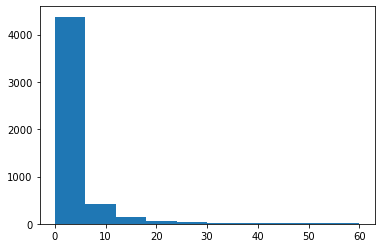

In [36]:
plt.hist(df_students_info['duration_bounded_mn']);

In [26]:
#save the info of interest only
df_students_info.rename(columns={'Zone':'Trackingsystem_Zone'}, inplace=True)
li_col = ['Timestamp','TagID', 'HenID', 'Trackingsystem_Zone', 'Observed_Zone','PenID','VideoAnalyse', 'system', 'date', 
          'signalstrength', 'signalstzone2', 'signalstrzone3', 'signalstrzone4','zone2_match','zone3_match','zone4_match',
          'next1_zone','next2_zone', 'next3_zone', 'next4_zone', 'next5_zone',
          'previous1_zone', 'previous2_zone', 'previous3_zone', 'previous4_zone','previous5_zone',
          'duration_bounded_mn','previous_duration_bounded_mn','algo_type','BatchID','previousZone==NextZone',
          'next_duration_bounded_mn',
          'next2zone==Zone','previous2zone==Zone','zone3_match_exist','is_first_observation']
df_students_info = df_students_info.filter(li_col, axis=1)
#shuffle before saving
df_students_info = shuffle(df_students_info, random_state=0)
df_students_info.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), sep=';', index=False)      

In [38]:
display(df_students_info[config.li_cont_select].head(3))
display(df_students_info[config.li_cat_select].head(3))

,signalstrength,signalstzone2,duration_bounded_mn,next_duration_bounded_mn,previous_duration_bounded_mn,next2zone==Zone,previous2zone==Zone,zone3_match_exist
4042,16.0,6.0,0.133333,0.766667,1.316667,1.0,1.0,1.0
1921,3.0,2.0,0.200000,8.533333,8.383333,1.0,1.0,0.0
4055,13.0,12.0,0.383333,0.100000,3.316667,1.0,1.0,1.0


,Trackingsystem_Zone,zone2_match,previous1_zone,next1_zone,system
4042,3_Zone,3_Zone,3_Zone,3_Zone,10 - 12
1921,3_Zone,2_Zone,2_Zone,2_Zone,10 - 12
4055,4_Zone,3_Zone,3_Zone,3_Zone,10 - 12


# Class label repartition

In [27]:
#per annotation
df_students_info.groupby(['algo_type','VideoAnalyse'])['Timestamp'].count().reset_index()
#--> cleaning dataset not only have more transisiotn per duraiton (by selection) but also a higher error rate (from the below
#table: with 12.5% against 5% in the verification dataset) #536/(536+3738), 43/(43+822)
#0.6% is the amount of missed transitions in the verification (as representatif of real data) dataset is of 5/(5+43+822)

,algo_type,VideoAnalyse,Timestamp
0,cleaning,0,536
1,cleaning,1,3738
2,verification,0,43
3,verification,1,822
4,verification,3,5


In [28]:
#by curiosity per zones for verification dataset
df_testing = df_students_info[df_students_info['algo_type']=='verification'].copy()
df_testing.groupby(['Trackingsystem_Zone','VideoAnalyse'])['date'].count().reset_index()

,Trackingsystem_Zone,VideoAnalyse,date
0,1_Zone,0,3
1,1_Zone,1,24
2,2_Zone,0,2
3,2_Zone,1,147
4,2_Zone,3,0
5,3_Zone,0,29
6,3_Zone,1,509
7,3_Zone,3,0
8,4_Zone,0,7
9,4_Zone,1,86


In [29]:
#by curiosity, per zones for cleaning dataset
df_cleaning = df_students_info[df_students_info['algo_type']=='cleaning'].copy()
df_cleaning.groupby(['Trackingsystem_Zone','VideoAnalyse'])['date'].count().reset_index()

,Trackingsystem_Zone,VideoAnalyse,date
0,2_Zone,0,15
1,2_Zone,1,901
2,3_Zone,0,468
3,3_Zone,1,1925
4,4_Zone,0,18
5,4_Zone,1,386
6,5_Zone,0,35
7,5_Zone,1,526


In [30]:
#confusion matrix of verification
confusion_matrix(df_testing['Observed_Zone'].tolist(), df_testing['Trackingsystem_Zone'].tolist())

array([[ 24,   0,   0,   0,   0],
       [  3, 148,  14,   0,   0],
       [  0,   2, 510,   2,   1],
       [  0,   0,   1,  88,   1],
       [  0,   0,  14,   5,  57]], dtype=int64)

In [31]:
#confusion matrix of cleaning
confusion_matrix(df_cleaning['Observed_Zone'].tolist(), df_cleaning['Trackingsystem_Zone'].tolist())

array([[ 902,   71,    0,   12],
       [  13, 1929,    8,   20],
       [   0,    9,  386,    3],
       [   1,  384,   10,  526]], dtype=int64)